In [1]:
from collections import defaultdict
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import nltk
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix

%load_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.pardir)
#print(module_path)
if module_path not in sys.path:
    sys.path.append(module_path)
    
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_auc_score

In [2]:
import numpy as np
import pandas as pd

# importing text preprocessing libraries
import nltk
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

In [3]:
# integrating our preprocessing into a pipeline
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.compose import ColumnTransformer

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline 

In [9]:
#import dataset
original_data = pd.read_csv('cleanedreview.csv')


In [12]:
data=original_data[['Pros','Cons','Rating']].dropna()

In [13]:
data.shape

(11203, 3)

In [14]:
#reduce rating classes to two - 1-3 or 4-5
data['GroupedRatings']=data['Rating'].apply(lambda x: "1-3" if x < 4 else "4-5" )

In [15]:
#change the class names for easier interpretation
data['RatingClass']=data['GroupedRatings'].apply(lambda x: 0 if x == "1-3" else 1 )

In [16]:
X = data[['Pros','Cons']]
y = data['RatingClass']

In [17]:
data.shape

(11203, 5)

## Baseline Modeling

In [230]:
#import modeling libraries

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import model_selection

from sklearn.model_selection import KFold

from sklearn.decomposition import NMF
from sklearn.manifold import TSNE


In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size = 0.3)

In [236]:
from sklearn.feature_extraction.text import TfidfVectorizer

pros=Pipeline([('pro_tfidf', TfidfVectorizer()),('pro_nmf',NMF(n_components = 5))])
cons=Pipeline([('con_tfidf', TfidfVectorizer()),('cons_nmf',NMF(n_components = 5))])

In [237]:
preprocess = ColumnTransformer([ 
     ("prospipe", pros,'Pros'),
     ("conspipe", cons,'Cons')])

In [227]:
# preprocess = ColumnTransformer(
#     [('pro_tfidf', TfidfVectorizer(), 'Pros'),
#      ('pro_nmf',NMF(n_components = 5), 'Pros'),
#     ('con_tfidf', TfidfVectorizer(), 'Cons'),
#     ('con_nmf',NMF(n_components = 5), 'Cons')])

In [238]:
X_train_processed=preprocess.fit_transform(X_train)

In [239]:
# Create a list of selected modeling algorithsm
models = []
models.append(('Logistic Regression', LogisticRegression(solver='liblinear', random_state=7,
                                                         class_weight='balanced')))
models.append(('Random Forest', RandomForestClassifier(
    n_estimators=100, random_state=7)))
models.append(('SVM', SVC(gamma='auto', random_state=7)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('Decision Tree Classifier',
               DecisionTreeClassifier(random_state=7)))
models.append(('Gaussian NB', GaussianNB()))

kfold = model_selection.KFold(n_splits=10, random_state=7)


/Users/Shen/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


In [240]:
acc_results = []
auc_results = []
names = []
#create a table for different scores
col = ['Algorithm', 'ROC AUC Mean', 'ROC AUC STD', 
       'Accuracy Mean', 'Accuracy STD']

df_results = pd.DataFrame(columns=col)

i = 0

# evaluate each model using cross-validation
for name, model in models:
    kfold = model_selection.KFold(
        n_splits=10, random_state=7)  # 10-fold cross-validation
    
    cv_acc_results = model_selection.cross_val_score(  # accuracy scoring
        model, X_train_processed, y_train, cv=kfold, scoring= 'accuracy')

    cv_auc_results = model_selection.cross_val_score(  # roc_auc scoring
        model, X_train_processed, y_train, cv=kfold, scoring='roc_auc')

    acc_results.append(cv_acc_results)
    auc_results.append(cv_auc_results)
    
    names.append(name)
    df_results.loc[i] = [name,
                         round(cv_auc_results.mean()*100, 2),
                         round(cv_auc_results.std()*100, 2),
                         round(cv_acc_results.mean()*100, 2),
                         round(cv_acc_results.std()*100, 2)
                         ]
    i += 1
df_results=df_results.sort_values(by=['ROC AUC Mean'], ascending=False)

/Users/Shen/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(
/Users/Shen/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(
/Users/Shen/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(
/Users/Shen/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/skle

,Algorithm,ROC AUC Mean,ROC AUC STD,Accuracy Mean,Accuracy STD
1,Random Forest,83.81,1.60,74.38,1.55
4,Decision Tree Classifier,69.51,1.44,69.47,1.48
0,Logistic Regression,66.74,1.96,62.43,1.78
3,KNN,66.21,1.56,62.08,1.14
2,SVM,65.72,1.85,60.61,2.05
5,Gaussian NB,63.21,2.12,57.61,2.18


In [244]:
df_results=df_results.sort_values(by=['ROC AUC Mean'], ascending=False)
df_results

,Algorithm,ROC AUC Mean,ROC AUC STD,Accuracy Mean,Accuracy STD
1,Random Forest,83.81,1.60,74.38,1.55
4,Decision Tree Classifier,69.51,1.44,69.47,1.48
0,Logistic Regression,66.74,1.96,62.43,1.78
3,KNN,66.21,1.56,62.08,1.14
2,SVM,65.72,1.85,60.61,2.05
5,Gaussian NB,63.21,2.12,57.61,2.18


In [245]:
df_results.to_csv('modelresults.csv')

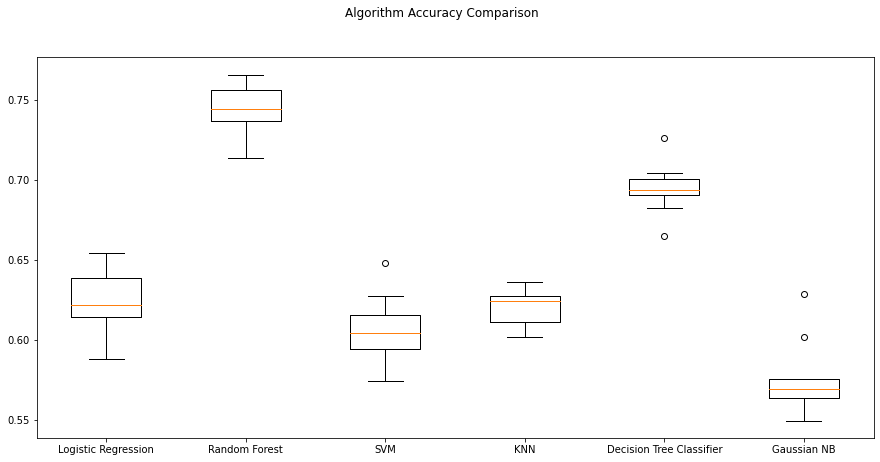

In [246]:
fig = plt.figure(figsize=(15, 7))
fig.suptitle('Algorithm Accuracy Comparison')
ax = fig.add_subplot(111)
plt.boxplot(acc_results)
ax.set_xticklabels(names)
plt.show()

## Model Tuning - Logistic Regression


In [247]:
%%time
from sklearn.model_selection import train_test_split, GridSearchCV,\
cross_val_score, RandomizedSearchCV


lr_pipe = Pipeline([('preprocess', preprocess),
                ('lr',LogisticRegression(random_state=42))])

# Fit the model to the training data

param_grid = [{'lr__C': np.arange(5,8, 0.1)}] # hyper-parameter list to fine-tune
log_gs = GridSearchCV(estimator = lr_pipe,
                      param_grid=param_grid,
                      scoring='roc_auc',
                      cv=10)

log_gs.fit(X_train, y_train)
log_opt = log_gs.best_estimator_
results = log_gs.cv_results_
y_pred = log_gs.predict(X_test)


print('='*20)
print("best params: " + str(log_gs.best_estimator_))
print("best params: " + str(log_gs.best_params_))
print('best score:', log_gs.best_score_)
print('='*20)
print(classification_report(y_test,y_pred))

best params: Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('prospipe',
                                                  Pipeline(steps=[('pro_tfidf',
                                                                   TfidfVectorizer()),
                                                                  ('pro_nmf',
                                                                   NMF(n_components=5))]),
                                                  'Pros'),
                                                 ('conspipe',
                                                  Pipeline(steps=[('con_tfidf',
                                                                   TfidfVectorizer()),
                                                                  ('cons_nmf',
                                                                   NMF(n_components=5))]),
                                                  'Cons')])),
                ('lr',
               

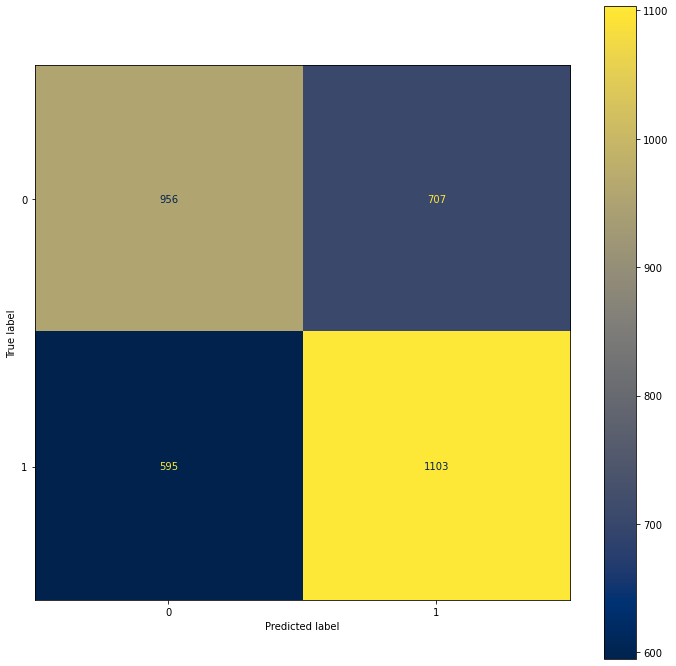

In [248]:
fig, ax = plt.subplots(figsize=(12,12))
plot_confusion_matrix(log_gs, X_test, y_test, ax=ax, cmap="cividis");

In [249]:
print(f'Accuracy Score: {accuracy_score(y_test,y_pred)}')
print(f'Precision Score: {precision_score(y_test,y_pred,)}')
print(f'Recall Score: {recall_score(y_test,y_pred)}')
print(f'F1 Score: {f1_score(y_test,y_pred)}')

Accuracy Score: 0.6126152930675394
Precision Score: 0.6093922651933702
Recall Score: 0.649587750294464
F1 Score: 0.62884834663626


## Model Tuning - Random Forrest

In [250]:
%%time
from sklearn.model_selection import train_test_split, GridSearchCV,\
cross_val_score, RandomizedSearchCV

rf_pipe = Pipeline([('preprocess', preprocess),
                ('rf',RandomForestClassifier(random_state=42))])


param_grid = {'rf__n_estimators':[50,70,80,100],
        'rf__criterion':['gini','entropy'],
        'rf__min_samples_leaf':[10,20,30],
        'rf__max_depth':[5,10,15,20,25],
        'rf__min_samples_split':[5,8,10,15]}  

 # hyper-parameter list to fine-tune
rf_gs = GridSearchCV(rf_pipe,# setting GridSearchCV                 
                      iid=True,
                      return_train_score=True,
                      param_grid=param_grid,
                      scoring='roc_auc',
                      cv=10)

rf_gs.fit(X_train, y_train)
tf_opt = rf_gs.best_estimator_
results = rf_gs.cv_results_
y_pred = rf_gs.predict(X_test)



print('='*20)
print("best params: " + str(rf_gs.best_estimator_))
print("best params: " + str(rf_gs.best_params_))
print('best score:', rf_gs.best_score_)
print('='*20)
print(classification_report(y_test,y_pred))

/Users/Shen/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


best params: Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('prospipe',
                                                  Pipeline(steps=[('pro_tfidf',
                                                                   TfidfVectorizer()),
                                                                  ('pro_nmf',
                                                                   NMF(n_components=5))]),
                                                  'Pros'),
                                                 ('conspipe',
                                                  Pipeline(steps=[('con_tfidf',
                                                                   TfidfVectorizer()),
                                                                  ('cons_nmf',
                                                                   NMF(n_components=5))]),
                                                  'Cons')])),
                ('rf',
               

In [251]:
print(f'Accuracy Score: {accuracy_score(y_test,y_pred)}')
print(f'Precision Score: {precision_score(y_test,y_pred,)}')
print(f'Recall Score: {recall_score(y_test,y_pred)}')
print(f'F1 Score: {f1_score(y_test,y_pred)}')

Accuracy Score: 0.6980065456709312
Precision Score: 0.6966033390903857
Recall Score: 0.7126030624263839
F1 Score: 0.7045123726346433


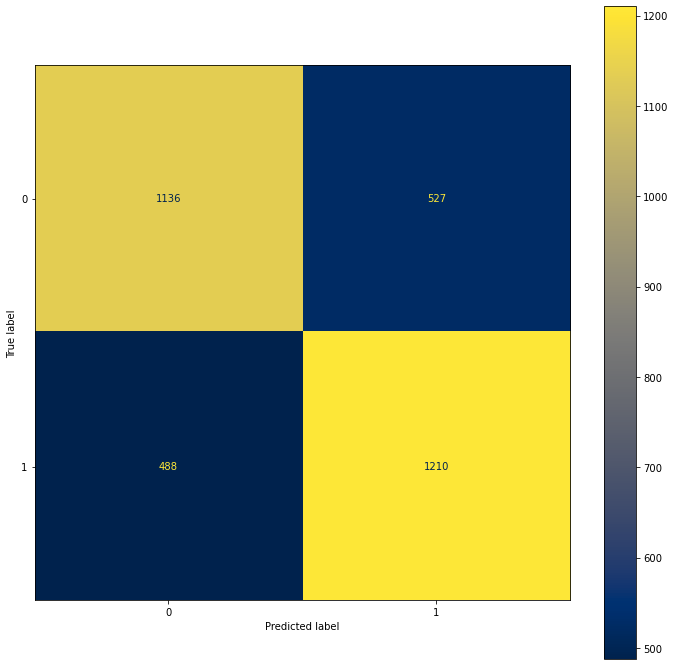

In [252]:
fig, ax = plt.subplots(figsize=(12,12))
plot_confusion_matrix(rf_gs, X_test, y_test, ax=ax, cmap="cividis")

In [254]:
rf_pipe = Pipeline([('preprocess', preprocess),
                ('rf',RandomForestClassifier(
                    criterion='entropy', max_depth=25,
                                        min_samples_leaf=10,
                                        min_samples_split=15,
                                    random_state=42))])

rf_pipe.fit(X_train, y_train)

RF_data=rf_pipe['rf'].feature_importances_

In [255]:
feature_data=RF_data

In [256]:
feature_data

array([0.11566977, 0.067013  , 0.08279239, 0.08070232, 0.10417361,
       0.06399422, 0.10927494, 0.06780254, 0.09307067, 0.21550654])

In [259]:
feature_topics = ['Pro-work_life_balance','Pro-learning_opportunities','Pro-benefit_pay', 'Pro-flexible_work_environment', 'Pro-nice_smart_people' ,'Con-work_pressure', 'Con-tight_deadline', 'Con-long_work_hours', 'Con-low_bonus_salary', 'Con-poor_management']

In [260]:
feature_importance=zip(feature_topics,feature_data)

In [262]:
feature_importance

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Pro-work_life_balance'),
  Text(1, 0, 'Pro-learning_opportunities'),
  Text(2, 0, 'Pro-benefit_pay'),
  Text(3, 0, 'Pro-flexible_work_environment'),
  Text(4, 0, 'Pro-nice_smart_people'),
  Text(5, 0, 'Con-work_pressure'),
  Text(6, 0, 'Con-tight_deadline'),
  Text(7, 0, 'Con-long_work_hours'),
  Text(8, 0, 'Con-low_bonus_salary'),
  Text(9, 0, 'Con-poor_management')])

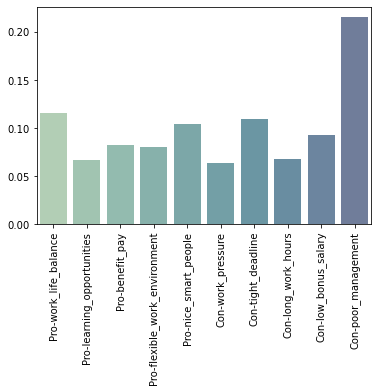

In [265]:
sns.barplot(x=feature_topics,y=feature_data,palette='crest',alpha=.7)
plt.xticks(rotation=90)
plt.xticks(rotation=90)

## Model Tuning - Decision Tree


In [268]:
%%time
from sklearn.model_selection import train_test_split, GridSearchCV,\
cross_val_score, RandomizedSearchCV

dt_clf = Pipeline([('preprocess', preprocess),
                ('dt',DecisionTreeClassifier(random_state=42))])


param_grid = {'dt__max_depth': [10,20,30],
    'dt__min_samples_leaf':[30,50],
    'dt__min_samples_split':[50,70,80],
    'dt__criterion':['entropy','gini']}  

 # hyper-parameter list to fine-tune
dt_gs = GridSearchCV(dt_clf,# setting GridSearchCV                 
                      param_grid=param_grid,cv=10)

dt_gs.fit(X_train, y_train)
dt_opt = dt_gs.best_estimator_
results = dt_gs.cv_results_
y_pred = dt_gs.predict(X_test)



print('='*20)
print("best params: " + str(dt_gs.best_estimator_))
print("best params: " + str(dt_gs.best_params_))
print('best score:', dt_gs.best_score_)
print('='*20)
print(classification_report(y_test,y_pred))

best params: Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('prospipe',
                                                  Pipeline(steps=[('pro_tfidf',
                                                                   TfidfVectorizer()),
                                                                  ('pro_nmf',
                                                                   NMF(n_components=5))]),
                                                  'Pros'),
                                                 ('conspipe',
                                                  Pipeline(steps=[('con_tfidf',
                                                                   TfidfVectorizer()),
                                                                  ('cons_nmf',
                                                                   NMF(n_components=5))]),
                                                  'Cons')])),
                ('dt',
               

## Model Tuning - StackingClassifier

In [269]:
from sklearn.ensemble import StackingClassifier

estimators = [
    ('multinb', MultinomialNB(alpha = 0.5,
                              fit_prior = False)),
    ('xgb', XGBClassifier(random_state = 51,
                          gamma = 5,
                          learning_rate = 0.2,
                          max_depth = 7,
                          min_child_weight = 10,
                          n_estimators = 200))
]

In [270]:
stacking = StackingClassifier(estimators)

In [271]:
pipe6 = Pipeline([
    ('preprocess', preprocess),
    ("ensemble", stacking)
])


# pipe_gs = GridSearchCV(pipe6,# setting GridSearchCV                 
#                       iid=True,
#                       return_train_score=True,
#                       scoring='roc_auc',
#                       cv=10)

In [272]:
pipe6.fit(X_train, y_train)
#pip_opt = pipe_gs.best_estimator_
#results = pipe6.cv_results_
y_pred = pipe6.predict(X_test)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.68      0.66      0.67      1663
           1       0.68      0.69      0.68      1698

    accuracy                           0.68      3361
   macro avg       0.68      0.68      0.68      3361
weighted avg       0.68      0.68      0.68      3361



In [277]:
from sklearn.ensemble import StackingClassifier

estimators2 = [
    ('rf',RandomForestClassifier(max_depth=25, min_samples_leaf=10,
                                        min_samples_split=5,
                                        random_state=42)),
    ('lr', LogisticRegression(random_state=42,C=5.23))
]

In [278]:
stacking2 = StackingClassifier(estimators2)

In [279]:
pipe7 = Pipeline([
    ('preprocess', preprocess),
    ("ensemble", stacking2)
])


In [280]:
pipe7.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('prospipe',
                                                  Pipeline(steps=[('pro_tfidf',
                                                                   TfidfVectorizer()),
                                                                  ('pro_nmf',
                                                                   NMF(n_components=5))]),
                                                  'Pros'),
                                                 ('conspipe',
                                                  Pipeline(steps=[('con_tfidf',
                                                                   TfidfVectorizer()),
                                                                  ('cons_nmf',
                                                                   NMF(n_components=5))]),
                                                  'Cons')])),
                ('ensemble',
                 Stack

In [281]:
y_pred = pipe6.predict(X_test)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.68      0.66      0.67      1663
           1       0.67      0.69      0.68      1698

    accuracy                           0.67      3361
   macro avg       0.67      0.67      0.67      3361
weighted avg       0.67      0.67      0.67      3361

